### Simplified SWI model, merging SmallScaleSWI setup

In [4]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
from set_rc import *

import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
import mplleaflet
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

In [5]:

#%% Useful functions

def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num

#%%

In [6]:
%%time
m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


CPU times: user 1min 3s, sys: 435 ms, total: 1min 3s
Wall time: 1min 3s


In [7]:
start_nm_yr = 1979
start_nm_mo = 10
start_nm_str = 'Oct 1979'
end_nm_yr = 2011
end_nm_mo = 9
end_nm_str = 'Sep 2011'
Lt_nm = ( (end_nm_yr + end_nm_mo/12)  - (start_nm_yr + start_nm_mo/12) )     *365
start_nm_datetime='{}/1/{}'.format(start_nm_mo,start_nm_yr)



start_m_yr = 1979
start_m_mo = 10
start_m_str = 'Oct 1979'
end_m_yr = 2011
end_m_mo = 9
end_m_str = 'Sep 2011'
Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)


In [8]:
#Name model
modelname = 'test_simpleSWI'
model_ws = workdir.joinpath("test_simpleSWI")
#Name model
sw_exe = config.swexe #set the exe path for seawat

#Model discretization
Lz = 150.

nrow,ncol,nlay,nper = m_nm.nrow_ncol_nlay_nper

# rows = np.arange(100,102)
rows = np.arange(164,165)
rows = np.arange(nrow)

cols = np.arange(ncol)
nrow =len(rows)
ncol = len(cols)
nlay=20


henry_top = 2
ocean_elev = 0
delv_first = 4
botm_first = henry_top-delv_first


delv = (Lz-delv_first) / (nlay-1)
delr = m_nm.dis.delr.array[0]
delc = m_nm.dis.delc.array[0]

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]


topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
henry_top = topo_grid[(slice(rows[0],rows[-1]+1),slice(cols[0],cols[-1]+1))]


# beachslope = .05
# ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
# ocean_col = [np.floor(ncol/2).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

# inland_elev = beachslope*ocean_col[0]*delr
# offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
# nyrs= 2
# Lt = 365*nyrs #Length of time in days

perlen = list(np.repeat(365/2,int(Lt_m/(365/2))))
nper = len(perlen)
nstp = np.ones_like(perlen,dtype=np.int)

# nstp = m_nm.dis.nstp.array
# perlen = m_nm.dis.perlen.array
# nper = m_nm.nper





steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.1
ssm_data = None
verbose = True

print('Model setup: \n'
      'nlay: {}\n'
      'nrow: {}\n'
      'ncol: {}\n'
      'Total cells: {}\n'
      'Total time: {} days\n'
      'nper: {}\n'.format(nlay,nrow,ncol,nlay*nrow*ncol,Lt_m,nper))
# In[4]:

#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws.as_posix(),verbose=verbose)
# SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,
                               start_datetime=start_m_datetime)

xll=595855
yll = 4059438
rotation=-13.5
# p = Proj(proj='utm',zone='10n',ellps='WGS84',units='meters', preserve_units=False)

m.DIS.lenuni = 2
m.DIS.itmuni=4
m.DIS.rotation=-13.5
# m.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m.DIS.proj4_str = p.srs
xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]


m.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(m.modelgrid)



Model setup: 
nlay: 20
nrow: 300
ncol: 345
Total cells: 2070000
Total time: 11649.583333333361 days
nper: 63

test_simpleSWI.nam
adding Package:  DIS
xll:595855.0; yll:4059438.0; rotation:-13.5; proj4_str:+proj=utm +zone=10 +datum=NAD83 +units=m +no_defs; units:undefined; lenuni:0


In [10]:
m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())


flopy.modflow.ModflowDis(m_empty, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,start_datetime=start_m_datetime)

m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')

### Gridgen: get lines

### Extract individual years from shapefiles

In [9]:
f_swi_180 = GISdir.joinpath("chloride_contours",'SWI_180_lines_noz.shp').as_posix()
swi_180 = sf.Reader(f_swi_180)
yrs_180 = [ int(r[-1]) for r in swi_180.records()]


for yr in yrs_180:
    f_exp = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_180.fields[1:] # skip first deletion field
        for feature in swi_180.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)

f_swi_400 = GISdir.joinpath("chloride_contours",'SWI_400_lines_noz.shp').as_posix()
swi_400 = sf.Reader(f_swi_400)
yrs_400 = [ int(r[-1]) for r in swi_400.records()]


for yr in yrs_400:
    f_exp = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_400.fields[1:] # skip first deletion field
        for feature in swi_400.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)      
                

In [10]:
layer =3
yr = yrs_180[-1]
f_shp_180 = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
int_180 = g.intersect(f_shp_180,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_180.nodenumber] = 1
a180 = a.reshape((nlay,nrow,ncol),order='C')


yr = yrs_400[-1]
f_shp_400 = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
int_400 = g.intersect(f_shp_400,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_400.nodenumber] = 1
a400 = a.reshape((nlay,nrow,ncol),order='C')


### Import salinity data

In [11]:
df_TDS = pd.read_excel(datadir.joinpath('WQ','export_TDS_data.xlsx'))
TDSij =[]
for x,y in zip(df_TDS.X_NAD83_UTM10N.values,df_TDS.Y_NAD83_UTM10N.values):
    try:
        TDSij.append(m_empty.modelgrid.intersect(x,y))
    except:
        TDSij.append((np.nan,np.nan))
df_TDS = df_TDS.assign(rowi=np.array(TDSij)[:,0])
df_TDS = df_TDS.assign(colj=np.array(TDSij)[:,1])

### Import AEM data

In [12]:
df_1719 = pd.read_pickle(datadir.joinpath('AEM','processed_df_1719.pkl'))
df = df_1719.loc[df_1719.skytem_type==304,:]

line = 100501

In [13]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.loc[msk,['LINE_NO']].values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'INVALT'].values[:]
# height = df.loc[msk,'TX_ALTITUDE'].values[:]
system = df.loc[msk,'skytem_type'].values[:]
msk_312 = system==312
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values


print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n'
'skytem_type',skytem_type.shape,'\n')

msk (25776,) 
xy (166, 2) 
Line (166, 1) 
dem (166,) 
height (166,) 
system (166,) 
rx_locations (166, 3) 
src_locations (166, 3) 
topo (166, 3) 
skytem_type (25776,) 



In [14]:
def intersect_swi_contour(aquifer=180,yr_ind=None):
    if aquifer==180:
        yr = yrs_180[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    elif aquifer==400:
        yr = yrs_400[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    else:
        raise('enter either 180 or 400')
    int_obj = g.intersect(f,'polygon',layer=layer)
    a = np.zeros((g.nodes), dtype=np.int)
    a[int_obj.nodenumber] = 1
    return a.reshape((nlay,nrow,ncol),order='C')


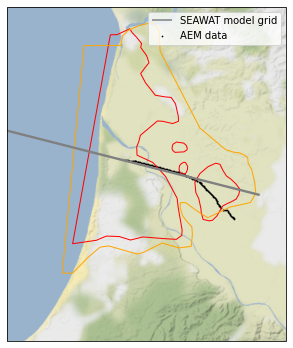

In [15]:
import cartopy
from matplotlib.transforms import offset_copy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11)

m_empty.modelgrid.plot(ax=ax,transform=transform,label='SEAWAT model grid')




ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)



plt.scatter(df.loc[msk,'UTMX'],df.loc[msk,'UTMY'],c='k',s=.5,transform=transform,label='AEM data ')


shp180 =  flopy.plot.plot_shapefile(f_shp_400,ax=ax,transform=transform,                        
                          facecolor='none',edgecolor='r',label='Cl. contour 180-FA')
shp400 =flopy.plot.plot_shapefile(f_shp_180,ax=ax,transform=transform,                        
                          facecolor='none',edgecolor='orange',label='Cl. contour 400-FA')
plt.legend()

Text(0, 0.5, 'UTM Y (NAD 83 Zone 10N)')

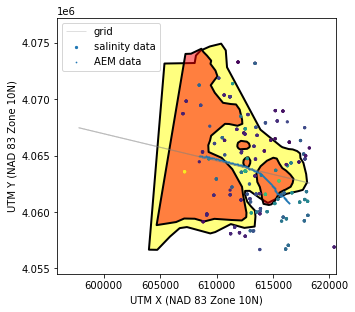

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotMapView(model=m_empty, layer=3,ax=ax)
xsect.plot_grid(linewidth=.5,label='grid',color=[.5,.5,.5,.5])

# xsect.plot_shapefile(swi_180)

# plt.plot(m_empty.modelgrid.xcellcenters.flatten(),m_empty.modelgrid.ycellcenters.flatten(),'k',label='refined seawat grid')
# xsect.plot_ibound(color_noflow='black')
# xsect.plot_shapefile(sharedir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yrs_400[-1])).as_posix(),facecolor=[0,0,0,0],edgecolor='k',linewidth=2)
xsect.plot_shapefile(f_shp_180,facecolor=[1,1,0,.5],edgecolor='k',linewidth=2)

xsect.plot_shapefile(f_shp_400,facecolor=[1,0,0,.5],edgecolor='k',linewidth=2)
plt.scatter(df_TDS.X_NAD83_UTM10N,df_TDS.Y_NAD83_UTM10N,s=5,c=np.log10(df_TDS.conc),label='salinity data')
plt.scatter(df.UTMX[msk],df.UTMY[msk],s=.5,label='AEM data')

# csa = xsect.plot_array(a180 + a400)
# csa = xsect.plot_array()
# plt.colorbar(csa)
# xsect.plot_bc('GHB')
ax.set_aspect(1)
plt.legend()
plt.xlim(m_nm.modelgrid.xvertices.min(),m_nm.modelgrid.xvertices.max())
plt.ylim(m_nm.modelgrid.yvertices.min(),m_nm.modelgrid.yvertices.max())

plt.xlabel('UTM X (NAD 83 Zone 10N)')
plt.ylabel('UTM Y (NAD 83 Zone 10N)')
# plt.savefig(figdir.joinpath('NMGWM_grid_vs_seawat_grid.png'),dpi=300,bbox_inches='tight')

In [12]:
from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator,griddata
# colvec = np.arange(0,ncol*delr+delr,delr)
# rowvec= np.arange(0,nrow*delc+delc,delc)
# colvec = colvec[:-1] +np.diff(colvec)/2
# rowvec = rowvec[:-1] +np.diff(rowvec)/2


xx,yy = np.meshgrid(np.cumsum(m.DIS.delc.array),np.cumsum(m.DIS.delr.array))
# xxn,yyn = np.meshgrid(np.cumsum(mn.DIS.delc.array),np.cumsum(mn.DIS.delr.array))

# def interp_surf2newgrid(orig_values):
#     return RectBivariateSpline(x=np.cumsum(m_nm.DIS.delc.array),
#                                 y=np.cumsum(m_nm.DIS.delr.array),
#                                 z=orig_values)(rowvec,colvec).round(decimals=1)
def get_colcent_rowcent(m):
    if len(m.dis.delr)>1:
        delr=m.dis.delr.array[0]
        delc=m.dis.delc.array[0]
    colvec = np.arange(0,m.ncol*delr+delr,delr)
    rowvec= np.arange(0,m.nrow*delc+delc,delc)
    colvec = colvec[:-1] +np.diff(colvec)/2
    rowvec = rowvec[:-1] +np.diff(rowvec)/2
    return colvec,rowvec


def interp_surf2newgrid_local(orig_values,m_old,m_new):
    colvec_old,rowvec_old = get_colcent_rowcent(m_old)
    colvec_new,rowvec_new = get_colcent_rowcent(m_new)
    return RectBivariateSpline(x=rowvec_old,
                                y=colvec_old,
                                z=orig_values)(rowvec_new,colvec_new).round(decimals=1)



# def interp_surf2newgrid_global(orig_values,m_old,m_new):
#     colvec_old,rowvec_old = get_colcent_rowcent(m_old)
#     colvec_new,rowvec_new = get_colcent_rowcent(m_new)
#     return RectBivariateSpline(x=rowvec_old,
#                                 y=colvec_old,
#                                 z=orig_values)(rowvec_new,colvec_new).round(decimals=1)


def make_surf_from_points(df_points,m_new,xval='x',yval='y',zval='z',method='nearest'):
    points = df_points.loc[:,[xval,yval]].values
    values = df_points.loc[:,zval].values
    grid_x = m_new.modelgrid.xcellcenters
    grid_y = m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)


def make_surf(grid_old,m_old,m_new,method='nearest'):
    points = np.stack((m_old.modelgrid.xcellcenters.flatten(),m_old.modelgrid.ycellcenters.flatten())).T
    values = grid_old.flatten()
    grid_x=  m_new.modelgrid.xcellcenters
    grid_y=  m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)


def NN_surf2newgrid(orig_values):
    d = orig_values.dtype
    interp_obj = NearestNDInterpolator(x=(xx.flatten(),yy.flatten()),y=orig_values.T.flatten())
    return interp_obj((xxn.flatten(),yyn.flatten())).reshape((mn.DIS.nrow,mn.DIS.ncol),order='F').astype(d)


In [13]:
botm_orig= m_nm.DIS.botm.array[:6]
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros((nlay,nrow,ncol),dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
#         botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        botm_orig_lay = make_surf(botm_orig[-1],m_nm,m_empty)
        ind_inlay = m_empty.dis.botm.array<botm_orig_lay
    else:
        botm_orig_lay = make_surf(botm_orig[lay],m_nm,m_empty)
        top_orig_lay = make_surf(botm_orig[lay-1],m_nm,m_empty)
        ind_inlay =np.logical_and(m_empty.dis.botm.array>=botm_orig_lay,m_empty.dis.botm.array<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay

In [14]:
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


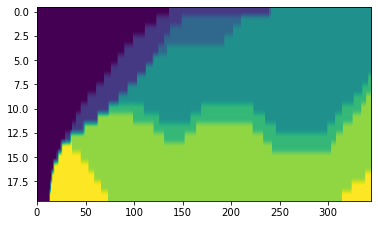

In [18]:
plt.imshow(layer_mapping_ind[:,100,:])
plt.gca().set_aspect(10)

Text(0, 0.5, 'UTM Y (NAD 83 Zone 10N)')

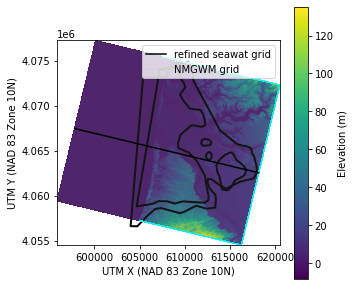

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotMapView(model=m_nm, layer=1,ax=ax)

xsect.plot_grid(linewidth=.5,label='NMGWM grid',color=[.5,.5,.5,.1])
csa = xsect.plot_array(m_nm.dis.top.array)
c= plt.colorbar(csa)
c.set_label('Elevation (m)')
plt.plot(m_empty.modelgrid.xcellcenters.flatten(),m_empty.modelgrid.ycellcenters.flatten(),'k',label='refined seawat grid')
xsect.plot_shapefile(f_shp_180,facecolor=[1,1,0,0],edgecolor='k',linewidth=2)
xsect.plot_shapefile(f_shp_400,facecolor=[1,0,0,0],edgecolor='k',linewidth=2)

# xsect.plot_ibound(color_noflow='white')
xsect.plot_bc('GHB')

ax.set_aspect(1)
plt.legend()
plt.xlabel('UTM X (NAD 83 Zone 10N)')
plt.ylabel('UTM Y (NAD 83 Zone 10N)')
# plt.savefig(figdir.joinpath('NMGWM_grid_vs_seawat_grid.png'),dpi=300,bbox_inches='tight')

Text(0.5, 0, 'Distance (m)')

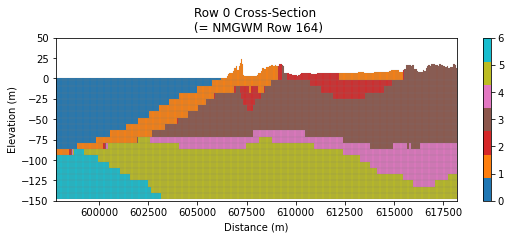

In [22]:
from matplotlib import cm

slicetype='Row'
slicenum= 0

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m_empty, line={slicetype: slicenum},geographic_coords=True,ax=ax)
xsect.plot_grid(linewidth=.1)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# conc[ibound==0]=np.nan
# hk = m_nm.lpf.hk.array
# hk[hk>1e4]=np.nan
# csa = xsect.plot_array(np.log(hk))

cmap = cm.get_cmap('tab10', 7)
csa = xsect.plot_array(layer_mapping_ind,cmap=cmap)
c = plt.colorbar(csa)

# wel = xsect.plot_bc("GHB")
# wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section \n (= NMGWM {slicetype} {slicenum_nmgwm})'.format(slicetype=slicetype,slicenum=slicenum,slicenum_nmgwm=rows[slicenum]))
plt.ylabel('Elevation (m)')
plt.ylim((-150,50))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [23]:
layers_nm = np.zeros((m_nm.nlay,m_nm.nrow,m_nm.ncol))
for lay in range(m_nm.nlay):
    layers_nm[lay,:,:]=lay

Text(0.5, 0, 'Distance (m)')

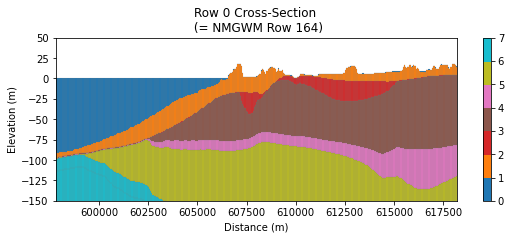

In [24]:
from matplotlib import cm

slicetype='Row'
slicenum= 0

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m_nm, line={slicetype: rows[slicenum]},geographic_coords=True,ax=ax)
xsect.plot_grid(linewidth=.1)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# conc[ibound==0]=np.nan
# hk = m_nm.lpf.hk.array
# hk[hk>1e4]=np.nan
# csa = xsect.plot_array(np.log(hk))

cmap = cm.get_cmap('tab10', 7)
csa = xsect.plot_array(layers_nm,cmap=cmap)
c = plt.colorbar(csa)

# wel = xsect.plot_bc("GHB")
# wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section \n (= NMGWM {slicetype} {slicenum_nmgwm})'.format(slicetype=slicetype,slicenum=slicenum,slicenum_nmgwm=rows[slicenum]))
plt.ylabel('Elevation (m)')
plt.ylim((-150,50))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [25]:
hk_nm = m_nm.lpf.hk.array
x_nm = m_nm.modelgrid.xcellcenters
y_nm = m_nm.modelgrid.ycellcenters
z_nm = m_nm.modelgrid.zcellcenters
x_m = m_empty.modelgrid.xcellcenters
y_m = m_empty.modelgrid.ycellcenters
z_m = m_empty.modelgrid.zcellcenters

hk_new = griddata(points=(np.tile(x_nm,(m_nm.dis.nlay,1,1)).flatten(),np.tile(y_nm,(m_nm.dis.nlay,1,1)).flatten(),z_nm.flatten()),
               values=hk_nm.flatten(),
               xi=(x_m,y_m,z_m),method='nearest')
hk_new[np.isnan(hk_new)] = np.max(hk_new[np.logical_and(layer_mapping_ind==1,hk_new<10000)])
hk_new[hk_new>10000] = np.max(hk_new[np.logical_and(layer_mapping_ind==1,hk_new<10000)])

In [26]:
# In[5]:

#Hydraulic conductivity field
hkSand = 1e2 #horizontal hydraulic conductivity m/day
hkClay = hkSand*.001

# heterogenous = 0 #0:homogenous,1:variogram,2:MPS

# hk = np.ones((nlay,nrow,ncol), dtype=np.float)
# hk[np.isin(layer_mapping_ind,(0,1,3,5))] = hkSand
# hk[np.isin(layer_mapping_ind,(2,4,6))] = hkClay


hk = hk_new 
#plt.figure(),plt.imshow((hk[:,0,:])),plt.colorbar(),plt.title('Sill:{}'.format(sill)),plt.show()

#Set Hydraulic properties
sy = 0.15
ss = 1e-5
por = 0.3
vka = .5 # = vk/hk
al = 20 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

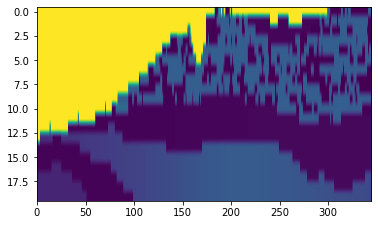

In [27]:
mps180 = np.load(MPSdir.joinpath('reals','mps180_16node.npy'))
mps180[mps180==1]=hkSand
mps180[mps180==0]=hkClay
hk2 = hk.copy()
hk2[np.where(layer_mapping_ind==3)] = mps180[np.where(layer_mapping_ind==3)] 
plt.imshow(np.ma.masked_where(hk2>600,hk2)[:,0,:])
plt.gca().set_aspect(10)


### BCs

#### Ocean side

In [28]:
def find_ocean(m,layer_mapping_ind):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((nlay,nrow,ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m,layer_mapping_ind)

In [29]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
cond = 1000.

ghb_data_ocean = {}
ssm_data_ocean = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = []
    ssm_per = []
    #Ocean boundary
    for v in np.argwhere(ocean_grid):
        ghb_per.append([v[0],
                       v[1],
                       v[2],
                       #ocean_hf[3][j],
                        ocean_elev,
                       cond])
        #SSM: {stress_period: [lay,row,col,concentration,itype]}
        ssm_per.append([v[0],
                       v[1],
                       v[2],
                       Csalt,
                       itype['GHB']])
    ghb_data_ocean[kper]=ghb_per
    ssm_data_ocean[kper]=ssm_per


kper 0
kper 50


##### Get ride of some ghb values 

In [30]:
inds = []
nix_ghb = []
for v in ocean_line.T:
# v = ocean_line.T[-1]
    if 6 in layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]:
        inds.append((v[0],v[1],int(np.argwhere(layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]==6)[0]) + v[2]))
        nix_ghb.append(v)

        
for kper in range(nper):
    for v in nix_ghb:
        try:
            ghb_data_ocean[kper].remove([v[0],v[1],v[2],0,cond])
        except:
            continue    

#### Inland side

In [31]:
def find_nearest_kper_nm(kper_m):
    t_m = (start_m_yr + start_m_mo/12) + np.sum(perlen[:kper_m])
    t_vec_nm = (start_nm_yr + start_nm_mo/12) + np.cumsum(m_nm.dis.perlen.array)    
    return np.argmin(abs(t_vec_nm-t_m))
    

In [32]:
def find_nearest_kper_nm(kper_m):
    t_m = (start_m_yr + start_m_mo/12) + np.sum(perlen[:kper_m])
    t_vec_nm = (start_nm_yr + start_nm_mo/12) + np.cumsum(m_nm.dis.perlen.array)    
    return np.argmin(abs(t_vec_nm-t_m))
    

layers_to_map=np.arange(3,6)
z_m_vert = m_empty.modelgrid.zvertices
ghb_data_nm = m_nm.ghb.stress_period_data.data


ghb_data_inland = {}
ssm_data_inland = {}



for kper_m in range(nper):
    kper_nm = find_nearest_kper_nm(kper_m)

#     if kper>0:
#         continue
    if kper_m%10==0:
        print('kper_m',kper_m,kper_nm)

    ghb_per=[]
    ssm_per = []
    for i,row in enumerate(rows):
        for lay in layers_to_map:
            msk = np.logical_and(np.logical_and(ghb_data_nm[kper_nm]['i']==i,ghb_data_nm[kper_nm]['j']==344),ghb_data_nm[kper_nm]['k']==lay)
            bhead = ghb_data_nm[kper_nm][msk]['bhead'][0]
            lay_map = np.argwhere(np.logical_and(layer_mapping_ind[:,i,344]==lay,z_m_vert[1:,i,344]<bhead)).flatten()
            for new_lay in lay_map:
                ghb_per.append((new_lay,i,344,bhead,cond))
                ssm_per.append([new_lay,i,344,Cfresh,itype['GHB']])
    ghb_data_inland[kper_m]=ghb_per
    ssm_data_inland[kper_m]=ssm_per

    


kper_m 0 0
kper_m 10 59
kper_m 20 119
kper_m 30 179
kper_m 40 239
kper_m 50 299
kper_m 60 359


In [33]:
yr_ind = np.argmin([np.min(abs(v - (start_m_yr + start_m_mo/12))) for v in yrs_180])
a_180 = intersect_swi_contour(aquifer=180,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_180]))
a_180 = np.tile(a_180[nonzerolay],(nlay,1,1))


yr_ind = np.argmin([np.min(abs(v - (start_m_yr + start_m_mo/12))) for v in yrs_400])
a_400 = intersect_swi_contour(aquifer=400,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_400]))
a_400 = np.tile(a_400[nonzerolay],(nlay,1,1))
salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)


salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_180[lay,row,:])
        if len(inds_nonzero)>0:
            salt_180[lay,row,:int(inds_nonzero[0])]=True
            
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_400[lay,row,:])
        if len(inds_nonzero)>0:
            salt_400[lay,row,:int(inds_nonzero[0])]=True


TypeError: only size-1 arrays can be converted to Python scalars

##### Ibound, strt, sconc, icbund

In [37]:
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
# for v in np.argwhere(ocean_grid):
#     ibound[v[0],v[1],:v[2]]=0
# head_inland =-10.
head_inland = min([np.min(np.array(v)[:,3]) for k,v in ghb_data_inland.items()])
ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
for lay in range(nlay):
    for row in range(nrow):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        ibound[lay,row,:col]=0
for v in inds:
    ibound[v[0],v[1],:v[2]]=0
ibound[z_m_vert[1:,:,:]>0]=0
ibound[layer_mapping_ind==6]=0

strt = np.ones_like(ibound)*head_inland

sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
sconc[ocean_grid] = Csalt
# interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
for v in ocean_line.T:
    sconc[v[0],v[1],:v[2]]=Csalt
    

    
    
sconc[np.logical_or(salt_180,salt_400)] = Csalt
    
    

icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[np.where(ibound==-1)] = -1

#### Join inland and ocean together

In [38]:
ghb_data = {}
ssm_data = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = ghb_data_ocean[kper]
    ssm_per = ssm_data_ocean[kper]
    for vg,vs in zip(ghb_data_inland[kper],ssm_data_inland[kper]):
        ghb_per.append(vg)
        ssm_per.append(vs)
    ghb_data[kper] = ghb_per
    ssm_data[kper] = ssm_per

kper 0
kper 50


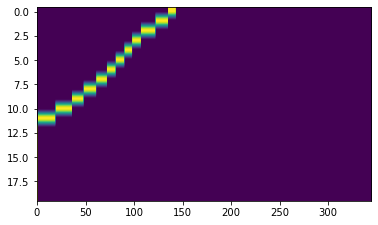

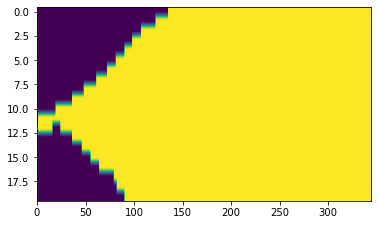

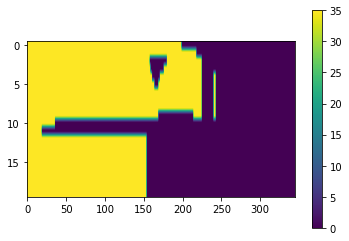

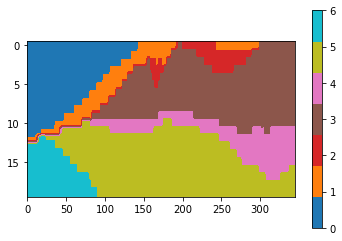

In [39]:
plt.figure() 
plt.imshow(ocean_grid[:,0,:])
# plt.scatter(np.array(badvals)[:,2],np.array(badvals)[:,0])
plt.gca().set_aspect(10)
# plt.colorbar()
plt.figure()
plt.imshow(ibound[:,0,:])
plt.gca().set_aspect(10)
plt.figure()
plt.imshow(sconc[:,0,:])
plt.gca().set_aspect(10)
plt.colorbar()

plt.figure()
cmap = cm.get_cmap('tab10', 7)

plt.imshow(layer_mapping_ind[:,0,:],cmap=cmap)
plt.gca().set_aspect(10)
plt.colorbar()

In [ ]:
# In[9]:

#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']


# In[10]:

#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

# rch = flopy.modflow.ModflowRch(m, rech=rech_data)
# wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
# riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)
# Add LPF package to the MODFLOW model
ipakcb = 53
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=0,laywet=0,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
timprs = np.cumsum(m.DIS.perlen.array)
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=lpf.laytyp, htop=henry_top,
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
# adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1 )
adv = flopy.mt3d.Mt3dAdv(m, mixelm=0,nadvfd=0 )

dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=3, cclose=1e-4)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data,mxss=len(ssm_data[0])*nper)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0,
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)

In [ ]:
from matplotlib import cm

slicetype='Row'
slicenum= 0

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True,ax=ax)
xsect.plot_grid(linewidth=.1)
xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
csa = xsect.plot_array(hk)

# cmap = cm.get_cmap('tab10', 7)
# csa = xsect.plot_array(layer_mapping_ind,cmap=cmap)
c = plt.colorbar(csa)
wel = xsect.plot_bc("GHB")
# wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,50))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [ ]:
%%time
runyn = True
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files

f_delete = [os.path.join(model_ws,'MT3D.CNF'),
            os.path.join(model_ws,'MT3D001.MAS'),
            os.path.join(model_ws, 'MT3D001.UCN'),
            os.path.join(model_ws, modelname + '.hds'),
            os.path.join(model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%
import datetime

if runyn:
    #Run model
    ts = make_timestamp()
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')
# In[14]:

In [ ]:
fname = Path(m.model_ws).joinpath('MT3D001.UCN').as_posix()
anyvals= []
ucnobj = flopy.utils.binaryfile.UcnFile(fname,verbose=False)
# if kstpkper==None:
kstpkpers = ucnobj.get_kstpkper()
for kstpkper in kstpkpers:
    conc = ucnobj.get_data(kstpkper=kstpkper)
    anyvals.append(np.logical_and(conc < 100., conc>0.).any())
print(np.all(anyvals))

In [ ]:
fname = Path(m.model_ws).joinpath(m.name +'.hds').as_posix()
hdobj = flopy.utils.binaryfile.HeadFile(fname,verbose=False)
kstpkpers = hdobj.get_kstpkper()
hd = hdobj.get_data(kstpkper=kstpkpers[-1])
hd[hd<-100]=np.nan

In [ ]:
from matplotlib import cm

slicetype='Row'
slicenum= nrow-1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True,ax=ax)
xsect.plot_grid(linewidth=.1)
xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
conc[ibound==0]=np.nan
conc[conc>Csalt*1.5]=np.nan

# csa = xsect.plot_array(np.log10(hk),cmap='Greys_r')
# csa = xsect.plot_array(conc,cmap='jet')
# csa = xsect.plot_array(layer_mapping_ind,cmap=cmap)

yr_ind = -1
a_180 = intersect_swi_contour(aquifer=180,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_180]))
a_180 = np.tile(a_180[nonzerolay],(nlay,1,1))
yr_ind =-1
a_400 = intersect_swi_contour(aquifer=400,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_400]))
a_400 = np.tile(a_400[nonzerolay],(nlay,1,1))

salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)

csa = xsect.plot_array((salt_180 + salt_400).astype(int),cmap='jet')


# cmap = cm.get_cmap('tab10', 7)


# csa = xsect.plot_array(conc,cmap='jet')
# c = plt.colorbar(csa)
chl_contour_conc  = 1/Csalt


csa = xsect.contour_array(conc,levels=np.array((chl_contour_conc,.05,.5,.95))*Csalt)
c = plt.colorbar(csa)

# cmap = cm.get_cmap('tab10', 7)
# csa = xsect.plot_array(layer_mapping_ind,cmap=cmap)
wel = xsect.plot_bc("GHB")
# wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,50))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [ ]:
import cartopy

import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11,alpha=1)

m_empty.modelgrid.plot(ax=ax,transform=transform,label='SEAWAT model grid')




ax.set_extent([600000., 620000.,4052000., 4075962.], crs=transform)


# Real model

In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

nmgwmdir_cal = Path('../data/Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
workdir = Path('../work')
datadir = Path('../data')
sharedir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')
figdir = Path('../work/figs')
outputdir = Path('../work/output')
# nmgwmdir_uncal = Path('../data/Scenarios/C1/C1-12')
# nmgwmdir_uncal = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/Scenarios/C1/C1-12')
import config
from set_rc import *

import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
import mplleaflet
import  pyproj
p = Proj(proj='utm',zone='10n',ellps='WGS84',units='meters', preserve_units=False)

flopy is installed in /Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy


In [3]:
%%time
m= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m.exe_name = config.mf2000exe

CPU times: user 1min 19s, sys: 659 ms, total: 1min 20s
Wall time: 1min 21s


In [5]:
xll=595855
yll = 4059438
rotation=-13.5
if not m.DIS.lenuni==2:
    m.DIS.delr *= .3048
    m.DIS.delc *= .3048
    m.DIS.top *= .3048
    m.DIS.botm *= .3048
    m.DIS.lenuni = 2
    m.DIS.rotation=-13.5
    m.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
    m.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
    m.DIS.proj4_str = p.srs
m.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(m.modelgrid)

xll:595855; yll:4059438; rotation:-13.5; proj4_str:+proj=utm +zone=10n +ellps=WGS84 +units=m ; units:meters; lenuni:2


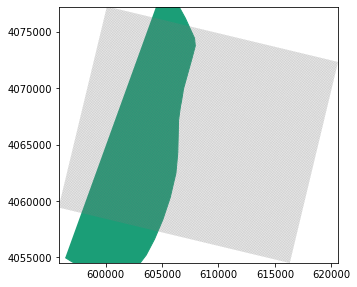

In [6]:
f,ax= plt.subplots(1,figsize=(5,5))
layer=0
modelmap = flopy.plot.PlotMapView(model=m,modelgrid=m.modelgrid,layer=layer)
modelmap.plot_grid(linewidth=.1)

ocean_line = sf.Reader(sharedir.joinpath("Ocean_surface",'Ocean_boundary.shp').as_posix())
modelmap.plot_shapefile(ocean_line)

# shape = sf.Reader(model_ws.joinpath('line_ocean_test').as_posix())
# flopy.plot.plot_shapefile(model_ws.joinpath('line_ocean_test').as_posix(),ax=ax,linewidth=10)
# plt.xlim(shape.bbox[0]-10000,shape.bbox[2]+10000)
# plt.xlim(shape.bbox[1],shape.bbox[3])
# plt.scatter(np.array(edge_list)[:,0],np.array(edge_list)[:,1])

#### New grid

In [7]:
#New model
model_ws = workdir.joinpath('nmgwm_seawat_2d')
if not model_ws.exists():
    model_ws.mkdir()
# mn = flopy.seawat.Seawat('nmgwm_seawat', exe_name=config.swexe, model_ws=model_ws.as_posix())
mn = flopy.modflow.Modflow('nmgwm_seawat', exe_name=config.swexe, model_ws=model_ws.as_posix())

In [8]:
# delr = 30.
# delc = 30.
# delv = 3.
bot_elev = -150
ocean_elev = 0

delr = m.DIS.delr.array
delc = m.DIS.delc.array
# delv =5
# nlay_1thru5 = 20
# nlay=nlay_1thru5+1
nlay_below = 20

delv = np.ceil(150/nlay_below).astype(int)
ncol =  np.floor(np.sum(delr)/delr[0]).astype(int)
nrow = np.floor(np.sum(delc)/delc[0]).astype(int)
top = np.ones((nrow,ncol))*ocean_elev


botm_vec=  np.arange(ocean_elev-delv,bot_elev-2*delv,-delv)


botm = np.ones((nlay_below,nrow,ncol),dtype=np.float)




for lay in range(nlay_below):
    botm[lay,:,:] = botm_vec[lay]

colvec = np.arange(0,ncol*delr[0],delr[0])
rowvec= np.arange(0,nrow*delc[0],delc[0])


dis = flopy.modflow.mfdis.ModflowDis(mn,nlay=nlay_below,nrow=nrow,ncol=ncol,
                                     delr=delr,delc=delc,
                                     top=top,botm=botm,laycbd=0,
                                     perlen=m.DIS.perlen.array,nper=m.DIS.nper,tsmult=m.DIS.tsmult.array,
                                     steady=False
                                     )
mn.DIS.lenuni = 2
mn.DIS.itmuni=4
mn.DIS.rotation=-13.5
mn.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
mn.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
mn.DIS.proj4_str = p.srs
mn.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(mn.modelgrid)

mn.sr = SpatialReference(delr=mn.dis.delr.array, delc=mn.dis.delc.array, 
                         xll=xll, yll=yll, rotation=rotation,proj4_str=p.srs)

xll:595855; yll:4059438; rotation:-13.5; proj4_str:+proj=utm +zone=10n +ellps=WGS84 +units=m ; units:meters; lenuni:2


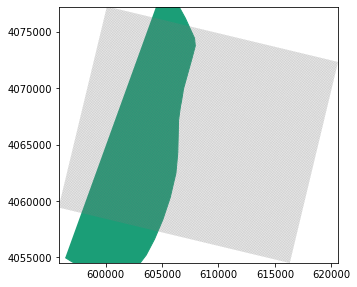

In [9]:
f,ax= plt.subplots(1,figsize=(5,5))
layer=0
modelmap = flopy.plot.PlotMapView(model=mn,modelgrid=mn.modelgrid,layer=layer)
modelmap.plot_grid(linewidth=.1)

ocean_line = sf.Reader(sharedir.joinpath("Ocean_surface",'Ocean_boundary.shp').as_posix())
modelmap.plot_shapefile(ocean_line)


# shape = sf.Reader(model_ws.joinpath('line_ocean_test').as_posix())
# flopy.plot.plot_shapefile(model_ws.joinpath('line_ocean_test').as_posix(),ax=ax,linewidth=10)
# plt.xlim(shape.bbox[0]-10000,shape.bbox[2]+10000)
# plt.xlim(shape.bbox[1],shape.bbox[3])
# plt.scatter(np.array(edge_list)[:,0],np.array(edge_list)[:,1])

In [10]:
from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator,griddata

def make_surf(df,xval='x',yval='y',zval='z',method='nearest'):
    points = df.loc[:,[xval,yval]].values
    values = df.loc[:,zval].values
    grid_x = m.modelgrid.xcellcenters
    grid_y = m.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)

xx,yy = np.meshgrid(np.cumsum(m.DIS.delc.array),np.cumsum(m.DIS.delr.array))
# xxn,yyn = np.meshgrid(np.cumsum(mn.DIS.delc.array),np.cumsum(mn.DIS.delr.array))

def interp_surf2newgrid(orig_values):
    return RectBivariateSpline(x=np.cumsum(m.DIS.delc.array),
                                y=np.cumsum(m.DIS.delr.array),
                                z=orig_values)(rowvec,colvec).round(decimals=1)

def NN_surf2newgrid(orig_values):
    d = orig_values.dtype
    interp_obj = NearestNDInterpolator(x=(xx.flatten(),yy.flatten()),y=orig_values.T.flatten())
    return interp_obj((xxn.flatten(),yyn.flatten())).reshape((mn.DIS.nrow,mn.DIS.ncol),order='F').astype(d)


#### Make topography

In [11]:
topo = pd.read_csv(sharedir.joinpath('Topography','Topography_vertices.csv'))
topo_red = topo.iloc[np.arange(0,len(topo),4),:]
topo_grid = make_surf(topo,method='nearest')
np.save(sharedir.joinpath('topo_grid.npy'),topo_grid)
# top[top<topo_grid]=topo_grid[top<topo_grid]

In [12]:
nlay_above=1
botm_above=np.zeros((nlay_above+1,nrow,ncol))  
for i in range(nrow):
    for j in range(ncol):
        botm_above[:,i,j]=np.linspace(topo_grid[i,j],top[i,j],nlay_above+1)
        
botm2 = np.concatenate((botm_above[1:],botm),axis=0)

top2 = botm_above[0]
top2[top2==botm2[0]]=top2[top2==botm2[0]]+delv

In [104]:
dis = flopy.modflow.mfdis.ModflowDis(mn,nlay=nlay_below+nlay_above,nrow=nrow,ncol=ncol,
                                     delr=delr,delc=delc,
                                     top=top2,botm=botm2,laycbd=0,
                                     perlen=m.DIS.perlen.array,nper=m.DIS.nper,tsmult=m.DIS.tsmult.array,
                                     steady=False
                                     )
botm = botm2
top = top2
mn.DIS.lenuni = 2
mn.DIS.itmuni=4
mn.DIS.rotation=-13.5
mn.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
mn.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
mn.DIS.proj4_str = p.srs
print(mn.modelgrid)

mn.sr = SpatialReference(delr=mn.dis.delr.array, delc=mn.dis.delc.array, 
                         xll=xll, yll=yll, rotation=rotation,proj4_str=p.srs)

# mn.nlay =nlay + nlay_above
# mn.DIS.top = top2
# mn.DIS.botm = botm2
nlay = mn.nlay
mn.update_modelgrid()

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...
xll:595855; yll:4059438; rotation:0.0; proj4_str:+proj=utm +zone=10n +ellps=WGS84 +units=m ; units:meters; lenuni:2


#### Find ocean line

#### Generate grid using gridgen

In [107]:
def get_line(start, end,allrows=False,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

### Find ocean line

In [108]:
ocean_grid = np.zeros_like(botm,dtype=np.bool)
ibound =np.ones_like(botm,dtype=np.int)
ocean_grid[:,:,0]=True

In [105]:
ocean = pd.read_csv(datadir.joinpath('GIS','ocean_surface','Ocean_3D_vertices.csv'))
m_ocean  = make_surf(ocean,method='linear')
ocean_topo = sf.Reader(datadir.joinpath('GIS','ocean_surface','Ocean_Boundary.shp').as_posix())

In [106]:
'''Alternative way to get the ocean line 
lay=19
ocean_int = g.intersect(model_ws.joinpath('line_ocean_lay{}'.format(lay)).absolute().as_posix(),'line',lay)
ocean_int = np.unique(ocean_int.nodenumber) # unique cells where recharge is applied, the np.unique also sorts the cell number
ijs = []
for i in np.arange(ocean_int.shape[0]):
    x,y = g.get_center(ocean_int[i]) #get the cell centroid x and y
    i,j = mn.modelgrid.intersect(x,y)            #get the cell row and column
    ijs.append((i,j))
'''

def get_ocean_line(lay,tol=delv/2):
#     tol=delv/2
    d = np.abs(m_ocean- mn.modelgrid.zcellcenters[lay])

    linevals = np.argwhere(d<tol).astype(int)
    
#     linevals = np.stack((np.arange(mn.DIS.nrow),d.argmin(axis=1))).T
    linemid = np.array([[r,np.median(linevals[linevals[:,0]==r][:,1]).astype(int)] for r in range(nrow)])
    linemid = (np.ones(len(linemid),dtype=np.int)*lay,
               linemid[:,0],
               linemid[:,1])
    rminds = np.zeros_like(linemid[0])
    for l in linemid:
        rminds = np.logical_or(rminds,l<0)
    linemid = [l[~rminds] for l in linemid]    

#     plt.imshow((d<tol).astype(int))
#     plt.plot(linemid[2],linemid[1])
    # plt.plot(linemid[:,1],linemid[:,0])
    #### coords = m.modelgrid.get_coords(linemid[1],linemid[2])
    #### edge_list = [[x,y] for x,y in zip(coords[0].astype(int),coords[1].astype(int))]
    #### edge_list = list(sorted(edge_list, key=lambda point: point[1]))

    x_coords = mn.modelgrid.xcellcenters[linemid[1],linemid[2]]
    y_coords = mn.modelgrid.ycellcenters[linemid[1],linemid[2]]

    edge_list = [[x,y] for x,y in zip(x_coords,y_coords)]
    edge_list = list(sorted(edge_list, key=lambda point: point[1]))

    w = sf.Writer(model_ws.joinpath('line_ocean_lay{}'.format(lay)).as_posix())
    w.field('name', 'C')
    w.line([edge_list,])
    w.record('linestring1')
    w.close()
    return linemid

for lay in range(nlay_below):
    get_ocean_line(lay)
# nodes=  []
# for v in edge_list:
#     nodes.append(m.modelgrid.intersect(v[0],v[1],forgive=True))
# nodes = [n for n in nodes if (not np.nan in n)]

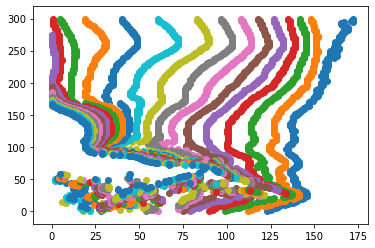

In [109]:
for lay in range(mn.DIS.nlay):
    line= get_ocean_line(lay,tol=delv)
    plt.scatter(line[2],line[1])


In [110]:
botm_orig= m.DIS.botm.array[:6]
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros_like(botm,dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
        botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        ind_inlay =botm<botm_orig_lay
    else:
        botm_orig_lay = interp_surf2newgrid(botm_orig[lay])
        top_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        ind_inlay =np.logical_and(botm>=botm_orig_lay,botm<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay

In [111]:
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


#### BAS

In [112]:
# ibound= np.ones_like(botm,dtype=np.int)
# for lay in range(m.DIS.nlay):
#     print(lay)
#     ibound_lay = NN_surf2newgrid(m.bas6.ibound.array[lay])
#     for newlay in range(nlay):
#         ibound[lay][layer_mapping_ind[newlay]==lay]=ibound_lay[layer_mapping_ind[newlay]==lay]
        
strt = np.ones_like(ibound,dtype=np.float)
strt[np.where(ocean_grid)]=0
# strt[ibound<0]=0.
# strt[ibound==0]=0.
bas = flopy.modflow.mfbas.ModflowBas(mn,ibound=ibound,strt=strt)

Text(0.5, 0, 'Distance (m)')

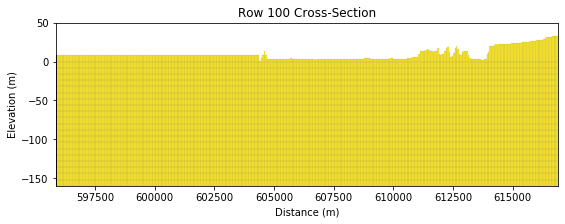

In [113]:
from matplotlib import cm

slicetype='Row'
slicenum= 100

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=mn, line={slicetype: slicenum},geographic_coords=True,ax=ax)
xsect.plot_grid(linewidth=.1)
xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
csa = xsect.plot_array(strt)
# cmap = cm.get_cmap('tab10', 7)
# csa = xsect.plot_array(layer_mapping_ind,cmap=cmap)
# c = plt.colorbar(csa)
# # wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-160,50))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

#### LPF

In [114]:
hk = np.ones_like(botm)*100
# hk[ibound<0]=7500
# hk[np.isin(layer_mapping_ind,(1,3,5,7))]=.01
# hk[np.isin(layer_mapping_ind,(2,4,6))]=10



In [1349]:
laytyp = np.ones(nlay,dtype=np.int)
# laytyp[0]=1
lpf = flopy.modflow.mflpf.ModflowLpf(mn,
                                    laytyp=laytyp,hk=hk)

NameError: name 'mn' is not defined

In [116]:
mn.write_input()
mg = mn.modelgrid

In [117]:
mn = flopy.seawat.Seawat.load('nmgwm_seawat.nam', exe_name=config.swexe, model_ws=model_ws.as_posix())


In [118]:
rows = [100,]
nrow = len(rows)
botm3 = botm[:,rows,:]
top3 = top[rows,:]
delc=dis.delr.array[0]*np.ones(len(rows))

dis = flopy.modflow.mfdis.ModflowDis(mn,nlay=nlay,nrow=nrow,ncol=ncol,
                                     delr=delr,delc=delc,
                                     top=top3,botm=botm3,laycbd=0,
                                     perlen=m.DIS.perlen.array,nper=m.DIS.nper,tsmult=m.DIS.tsmult.array,
                                     steady=False
                                     )
mn.DIS.lenuni = 2
mn.DIS.itmuni=4
# mn.DIS.rotation=-13.5
# mn.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# mn.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
# mn.DIS.proj4_str = p.srs
# mn.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
# print(mn.modelgrid)

# mn.sr = SpatialReference(delr=mn.dis.delr.array, delc=mn.dis.delc.array, 
#                          xll=xll, yll=yll, rotation=rotation,proj4_str=p.srs)
# mn.update_modelgrid()
# mn.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...


In [119]:
ibound3 = mn.bas6.ibound.array[:,rows,:]
strt3 = mn.bas6.strt.array[:,rows,:]
hk3  = mn.lpf.hk.array[:,rows,:]
layer_mapping_ind3 = layer_mapping_ind[:,rows,:]
ocean_grid3 = ocean_grid[:,rows,:]

In [120]:

bas = flopy.modflow.mfbas.ModflowBas(mn,ibound=ibound3,strt=strt3)
lpf = flopy.modflow.mflpf.ModflowLpf(mn,
                                    laytyp=laytyp,hk=hk3)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


In [121]:
ibound = ibound3
strt = strt3
hk= hk3 
layer_mapping_ind = layer_mapping_ind3
ocean_grid = ocean_grid3

## Transport

#### BTN, ADV, DSP, GCG

In [122]:
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)



icbund = np.ones_like(ibound,dtype=int)
icbund[ibound<0] = -1
icbund[ibound==0] = 0


sconc = np.zeros_like(ibound,dtype=np.float)
sconc[np.where(ocean_grid)]=Csalt
sconc[icbund<0]=Cfresh


prsity= 0.2
sconc=0.
al = 10
dmcoef = 1e-9
timprs = np.cumsum(mn.DIS.perlen.array)


btn=flopy.mt3d.Mt3dBtn(mn,
                laycon=mn.lpf.laytyp, htop=mn.DIS.top.array,
                dz=mn.DIS.thickness.get_value(), prsity=prsity, icbund=icbund,
                sconc=sconc, nprs=1, timprs=timprs)
adv=flopy.mt3d.Mt3dAdv(mn, mixelm=-1)
dsp=flopy.mt3d.Mt3dDsp(mn , al=al, dmcoef=dmcoef)
gcg=flopy.mt3d.Mt3dGcg(mn , iter1=50, mxiter=1, isolve=1, cclose=1e-5)

#### GHB


In [123]:
ghb_orig = m.GHB.stress_period_data.data
ghb_new =  {}

for kper in range(mn.DIS.nper):
    ghb_kper=[]
    if kper%50==0:
        print('kper',kper)
#     for v in ghb_orig[kper]:
    for irow,row in enumerate(rows):
        msk = ghb_orig[kper]['i']==row
        for v in ghb_orig[kper][msk]:
            lays = np.argwhere(layer_mapping_ind[:,irow,v[2]]==v[0])
            for l in lays:
                ghb_kper.append([int(l),
                                irow,
                                v[2],
                                 20.,
#                                 v[3],
                                10000.])
        #Ocean GHB
        for v in np.argwhere(ocean_grid):
            ghb_kper.append([v[0],
                            v[1],
                            v[2],
                             0.,
                            10000.])

    ghb_new[kper]=ghb_kper

kper 0
kper 50
kper 100
kper 150
kper 200
kper 250
kper 300
kper 350


In [124]:
ghb = flopy.modflow.ModflowGhb(mn, stress_period_data=ghb_new)

#### SSM

In [125]:
itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_new =  {}

print('Adding Inland SSM...')
#GHB
for kper in range(mn.DIS.nper):
    ssm_kper = []
    if kper%100==0:
        print('kper',kper)
    for v in ghb_new[kper]:
        ssm_kper.append([v[0],
                        v[1],
                        v[2],
                        Cfresh,
                        itype['GHB']])
    ssm_new[kper] = ssm_kper

    

print('Adding Ocean SSM...')
#Ocean
for kper in range(mn.DIS.nper):
    if kper%100==0:
        print('kper',kper)
    for v in np.argwhere(ocean_grid):
        ssm_new[kper].append([v[0],
                        v[1],
                        v[2],
                        Csalt,
                        itype['GHB']])

Adding Inland SSM...
kper 0
kper 100
kper 200
kper 300
Adding Ocean SSM...
kper 0
kper 100
kper 200
kper 300


In [135]:
ssm = flopy.mt3d.Mt3dSsm(mn, stress_period_data=ssm_new,mxss=2000)


****Warning -- two packages of the same type:  <class 'flopy.mt3d.mtssm.Mt3dSsm'> <class 'flopy.mt3d.mtssm.Mt3dSsm'>
replacing existing Package...


#### VDF

In [136]:
vdf = flopy.seawat.SeawatVdf(mn, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1,
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


****Warning -- two packages of the same type:  <class 'flopy.seawat.swtvdf.SeawatVdf'> <class 'flopy.seawat.swtvdf.SeawatVdf'>
replacing existing Package...


#### OC

In [137]:
oc_data={}
for kper in range(mn.DIS.nper):
    if kper % 5==0:
        oc_data[(kper, 0)] = ['save head', 'save budget']
oc =  flopy.modflow.ModflowOc(mn,stress_period_data=oc_data,compact=True)


****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


Text(0.5, 0, 'Distance (m)')

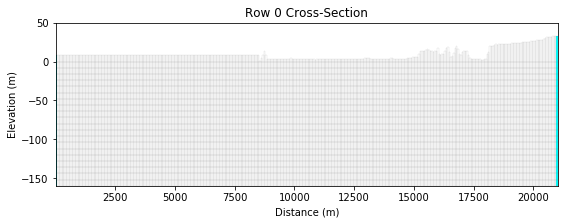

In [138]:
from matplotlib import cm

slicetype='Row'
slicenum= 0

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=mn, line={slicetype: slicenum},geographic_coords=True,ax=ax)
xsect.plot_grid(linewidth=.1)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(strt)
# cmap = cm.get_cmap('tab10', 7)
# csa = xsect.plot_array(layer_mapping_ind,cmap=cmap)
# c = plt.colorbar(csa)
# wel = xsect.plot_bc("SSM")
wel = xsect.plot_bc("GHB")


t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-160,50))
# plt.xlim((-10,20000))

plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

#### Write it all

In [139]:
%%time
write_all=True

if write_all:
    print('Writing input, this will take a while...')
    mn.write_input()
else:
    print('Not writing input!!')

# Try to delete the output files, to prevent accidental use of older files
flist = [model_ws.joinpath('MT3D.CNF').as_posix(),
         model_ws.joinpath('MT3D001.MAS').as_posix(),
         model_ws.joinpath(mn.name + '.hds').as_posix(),
         model_ws.joinpath('MT3D001.UCN').as_posix(),
         model_ws.joinpath('MT3D001.UCN').as_posix(),
         model_ws.joinpath(mn.name + '.cbc').as_posix()]
for f in flist:
    try:
        os.remove(f)
    except:
        pass

Writing input, this will take a while...
CPU times: user 777 ms, sys: 17.1 ms, total: 794 ms
Wall time: 845 ms


In [140]:
mn.check()


nmgwm_seawat MODEL DATA VALIDATION SUMMARY:
  1 Error:
    DIS package: thin cells (less than checker threshold of 1.0)

  Checks that passed:
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000.0
    LPF package: zero or negative specific storage v

In [141]:
mn.run_model(report=False)

FloPy is using the following  executable to run the model: /usr/local/bin/MODFLOW/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: nmgwm_seawat.nam                                                                                                                                                                                        
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/05/22 11:59:15


 STRESS PERIOD NO.    1

  STRESS PERIO

(True, [])

### Plotting

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/flopy/plot/map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


TypeError: Dimensions of C (300, 345) are incompatible with X (346) and/or Y (2); see help(pcolormesh)

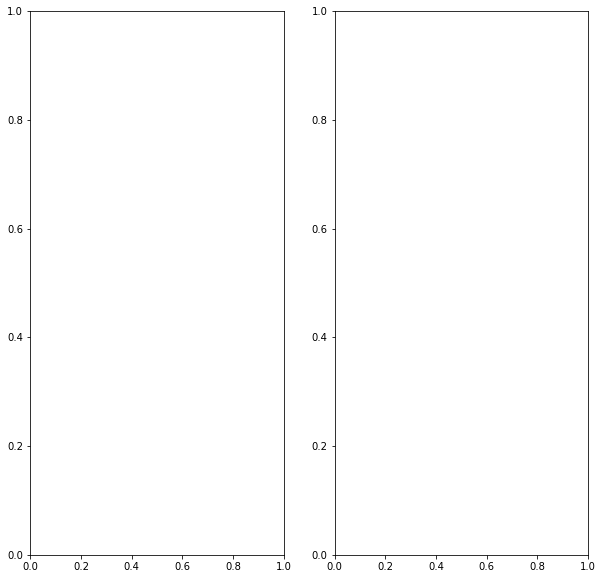

In [187]:
slicenum=0


f,axs = plt.subplots(1,2,figsize=(10,10))
plt.sca(axs[0])
ax = plt.gca()

mapview = flopy.plot.ModelMap(ax=ax,model=mn,layer=slicenum,dis=mn.DIS)
patches = mapview.plot_ibound()
patches = mapview.plot_bc('GHB')

# a = m.DIS.top.array.astype(np.float) -  m.DIS.botm.array.astype(np.float)[0]
# p = mapview.plot_array(a)
# plt.colorbar(p)
# mapview.plot_grid()
ax.set_aspect(1)
ax.grid(True)


slicenum=0
plt.sca(axs[1])
ax = plt.gca()
mapview = flopy.plot.ModelMap(ax=ax,model=m,layer=slicenum,dis=m.DIS)
patches = mapview.plot_ibound()
patches = mapview.plot_bc('GHB')

# a = m.DIS.top.array.astype(np.float) -  m.DIS.botm.array.astype(np.float)[0]
# p = mapview.plot_array(a)
# plt.colorbar(p)
# mapview.plot_grid()
ax.set_aspect(1)
ax.grid(True)


In [55]:
fname = model_ws.joinpath('MT3D001.UCN').as_posix()
anyvals= []
ucnobj = flopy.utils.binaryfile.UcnFile(fname,verbose=False)
# if kstpkper==None:
kstpkpers = ucnobj.get_kstpkper()
for kstpkper in kstpkpers:
    conc = ucnobj.get_data(kstpkper=kstpkper)
    anyvals.append(np.logical_and(conc < 100., conc>0.).any())
print(anyvals)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [56]:
fname = model_ws.joinpath(mn.name +'.hds').as_posix()
hdobj = flopy.utils.binaryfile.HeadFile(fname,verbose=False)
kstpkpers = hdobj.get_kstpkper()
hd = hdobj.get_data(kstpkper=kstpkpers[-1])
hd[hd<-100]=np.nan

NameError: name 'mn' is not defined

In [144]:
hd = hdobj.get_data(kstpkper=kstpkpers[-1])
hd

array([[[0., 1., 1., ..., 1., 1., 1.]],

       [[0., 1., 1., ..., 1., 1., 1.]],

       [[0., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[0., 1., 1., ..., 1., 1., 1.]],

       [[0., 1., 1., ..., 1., 1., 1.]],

       [[0., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

Text(0.5, 0, 'Distance (m)')

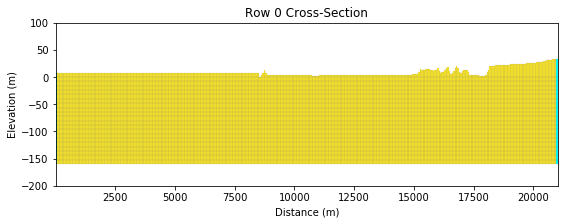

In [146]:
from matplotlib import cm

slicetype='Row'
slicenum= 0

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=mn, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(hd,cmap='viridis')
# c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_bc("GHB")



t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

Text(0.5, 0, 'Distance (m)')

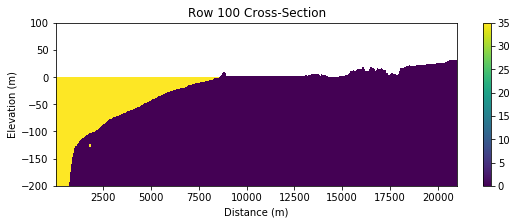

In [676]:
from matplotlib import cm

slicetype='Row'
slicenum= 100

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=mn, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(sconc,cmap='viridis')
c = plt.colorbar(csa)
# # wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-200,100))
plt.xlabel('Distance (m)')
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('seawat_fine_xsection_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')

In [ ]:
from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator,griddata

def make_surf(df,xval='x',yval='y',zval='z',method='nearest'):
    points = df.loc[:,[xval,yval]].values
    values = df.loc[:,zval].values
    grid_x = m.modelgrid.xcellcenters
    grid_y = m.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)

xx,yy = np.meshgrid(np.cumsum(m.DIS.delc.array),np.cumsum(m.DIS.delr.array))
# xxn,yyn = np.meshgrid(np.cumsum(mn.DIS.delc.array),np.cumsum(mn.DIS.delr.array))

def interp_surf2newgrid(orig_values):
    return RectBivariateSpline(x=np.cumsum(m.DIS.delc.array),
                                y=np.cumsum(m.DIS.delr.array),
                                z=orig_values)(rowvec,colvec).round(decimals=1)

def NN_surf2newgrid(orig_values):
    d = orig_values.dtype
    interp_obj = NearestNDInterpolator(x=(xx.flatten(),yy.flatten()),y=orig_values.T.flatten())
    return interp_obj((xxn.flatten(),yyn.flatten())).reshape((mn.DIS.nrow,mn.DIS.ncol),order='F').astype(d)


In [674]:
mn.BTN.sconc

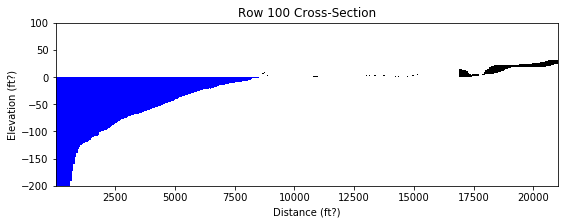

In [577]:
from matplotlib import cm

slicetype='Row'
slicenum= 100

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
patches = xsect.plot_ibound()
# a= m.lpf.hk.array
# a[a<=0]=np.nan
# a=np.log(a)


# lay_m = np.zeros_like(m.lpf.hk.array)
# for lay in range(lay_m.shape[0]):
#     lay_m[lay,:,:]=lay
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# csa = xsect.plot_array(lay_m,cmap=cmap)
# c = plt.colorbar(csa)
# # wel = xsect.plot_bc("WEL")

t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (ft?)')
plt.ylim((-200,100))
plt.xlabel('Distance (ft?)')
# c.set_label('log10(hk)')
plt.savefig(figdir.joinpath('NMGWM_orig_layers_{slicetype}{slicenum}.png'.format(slicetype=slicetype,slicenum=slicenum)),dpi=300,bbox_inches='tight')